In [58]:
import os
import netket as nk
import numpy as np
import matplotlib.pyplot as plt

import netket.nn as nknn
import flax.linen as nn
import jax.numpy as jnp

In [59]:
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [60]:
J = [1, 0.2]
L = 14

In [61]:
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i + 1) % L, 1])
    edge_colors.append([i, (i + 2) % L, 2])

g = nk.graph.Graph(edges=edge_colors)

In [62]:
sigmaz = [[1,0], [0, -1]]
mszsz = np.kron(sigmaz, sigmaz)

exchange = np.asarray([[0,0,0,0],[0,0,2,0], [0,2,0,0],[0,0,0,0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),
    (J[0] * exchange).tolist(),
]


bond_color = [1, 2, 1, 2]

In [63]:
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)

In [64]:
op = nk.operator.GraphOperator(
    hi,
    graph=g,
    bond_ops=bond_operator,
    bond_ops_colors=bond_color
)

In [65]:
class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        nn.Dense(
            features = (2 * x.shape[-1]),
            use_bias= True,
            param_dtype= np.complex128,
            kernel_init= nn.initializers.normal(stddev=0.01),
            bias_init = nn.initializers.normal(stddev=0.01)
        )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x

model = FFNN()

In [77]:
sampler = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max=2)

variational_state = nk.vqs.MCState(sampler=sampler, model=model, n_samples=1008)


optimizer = nk.optimizer.Adam(learning_rate=1e-4)  # or even 5e-5

sr = nk.optimizer.SR(
    diag_shift=0.01,
    qgt=nk.optimizer.qgt.QGTJacobianDense,
)

gs = nk.driver.VMC(
    hamiltonian=op,
    optimizer=optimizer,
    variational_state=variational_state,
    preconditioner=sr,
)

/var/folders/33/28753zc950g7jnqk3b6ljhdr0000gn/T/ipykernel_21588/359415146.py:11: DeprecationWarning: netket.nn.log_cosh is deprecated: use netket.nn.activation.log_cosh
  x = nknn.log_cosh(x)


In [81]:
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hilbert=hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (
            (nk.operator.spin.sigmaz(hi, i) * nk.operator.spin.sigmaz(hi, j))
            * ((-1) ** (i - j))
            / L
        )

/Users/ramtinhosseini/Desktop/Neural Network Quantum State/venv/lib/python3.13/site-packages/netket/operator/_local_operator/base.py:348: OperatorMultiplicationDeprecationWarning: 
The '*' operator for multiplying operators is deprecated and will be removed in a future version.

Please use the '@' operator instead:
  - Replace: operator1 * operator2
  - With:    operator1 @ operator2

The '@' operator is Python's standard matrix multiplication operator.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_generated/errors/netket.errors.OperatorMultiplicationDeprecationWarning.html
or the list of all common errors and warnings at
	 https://netket.readthedocs.io/en/latest/api/errors.html
-------------------------------------------------------

  warnings.warn(OperatorMultiplicationDeprecationWarning())


In [82]:
gs.run(out="test", n_iter=600, obs={"Structure Factor": structure_factor})

100%|██████████| 600/600 [00:37<00:00, 15.95it/s, Energy=-1.25 ± 0.28 [σ²=7.8e+01, R̂=1.003]]


(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.18082094192504883
   	Params: 0.17678308486938477,)

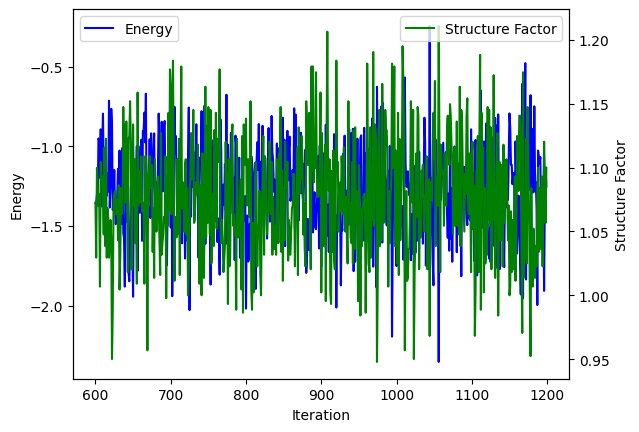

In [84]:
import json
import numpy as np
import matplotlib.pyplot as plt

# --- Load data ---
data = json.load(open("test.log"))

iters  = data["Energy"]["iters"]
energy = data["Energy"]["Mean"]     # list of floats

# --- Extract structure factor (sf) safely ---
SF_mean = data["Structure Factor"]["Mean"]

if isinstance(SF_mean, dict):
    # Format: {"real": [...], "imag": [...]}
    sf = SF_mean["real"]
elif isinstance(SF_mean, list) and len(SF_mean) > 0 and isinstance(SF_mean[0], dict):
    # Format: [ {"real": x, "imag": y}, ... ]
    sf = [d["real"] for d in SF_mean]
else:
    # Already list of floats
    sf = SF_mean

sf = np.array(sf)

# --- Combined plot (Energy + Structure Factor) ---
fig, ax1 = plt.subplots()

ax1.plot(iters, energy, color="blue", label="Energy")
ax1.set_ylabel("Energy")
ax1.set_xlabel("Iteration")

ax2 = ax1.twinx()
ax2.plot(iters, sf, color="green", label="Structure Factor")
ax2.set_ylabel("Structure Factor")

ax1.legend(loc=2)   # upper left
ax2.legend(loc=1)   # upper right

plt.show()




In [75]:
import json

data = json.load(open("test.log"))

# Energy is a plain list of floats in your case
energy = data["Energy"]["Mean"]

final_energy = energy[-1]
print("Final energy:", final_energy)

Final energy: -1.4000000000000004


In [76]:
print(
    rf"Structure factor = {np.mean(sf[-50:]):.3f}({np.std(np.array(sf[-50:]))/np.sqrt(50):.3f})"
)
print(
    rf"Energy = {np.mean(energy[-50:]):.3f}({np.std(energy[-50:])/(np.sqrt(50)):.3f})"
)

Structure factor = 1.067(0.005)
Energy = -1.290(0.033)


In [72]:
E_gs, ket_gs = nk.exact.lanczos_ed(op, compute_eigenvectors=True)
structure_factor_gs = (
    ket_gs.T.conj() @ structure_factor.to_linear_operator() @ ket_gs
).real[0, 0]

In [73]:
print(f"Exact Ground-state Structure Factor: {structure_factor_gs:.3f}")
print(f"Exact ground state energy = {E_gs[0]:.3f}")

Exact Ground-state Structure Factor: 0.971
Exact ground state energy = -23.352
